In [19]:
from datasets import load_dataset, concatenate_datasets
from PIL import Image
import numpy as np
import cupy as cp

from cuml.model_selection import train_test_split, StratifiedKFold
from cuml.preprocessing import StandardScaler
from cuml.svm import SVC
from cuml.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [20]:
ds = load_dataset("Bingsu/Cat_and_Dog")

def make_balanced_subset(dataset, n_total, seed=42):
    d0 = dataset.filter(lambda ex: ex["labels"] == 0)
    d1 = dataset.filter(lambda ex: ex["labels"] == 1)
    n_per = min(n_total // 2, len(d0), len(d1))
    d0s = d0.shuffle(seed=seed).select(range(n_per))
    d1s = d1.shuffle(seed=seed).select(range(n_per))
    return concatenate_datasets([d0s, d1s]).shuffle(seed=seed)

N_TRAIN = 4000
N_TEST  = 200

ds_train = make_balanced_subset(ds["train"], N_TRAIN, seed=42)
ds_test  = make_balanced_subset(ds["test"],  N_TEST,  seed=123)


Filter: 100%|██████████| 2000/2000 [00:01<00:00, 1850.81 examples/s]


In [21]:
from transformers import AutoImageProcessor, AutoModel
import torch

BACKBONE = "google/vit-base-patch16-224-in21k"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained(BACKBONE)
model = AutoModel.from_pretrained(BACKBONE).to(DEVICE).eval()

@torch.no_grad()
def embed_batch(pil_list):
    inputs = processor(images=pil_list, return_tensors="pt").to(DEVICE)
    out = model(**inputs).last_hidden_state[:, 0, :] 
    return out.detach().cpu().numpy().astype("float32")

def batch_iter(dataset, batch_size):
    imgs, labels = [], []
    for ex in dataset:
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        imgs.append(img)
        labels.append(int(ex["labels"]))
        if len(imgs) == batch_size:
            yield imgs, np.array(labels, dtype=np.int32)
            imgs, labels = [], []
    if imgs:
        yield imgs, np.array(labels, dtype=np.int32)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 7244.05it/s]


In [22]:
BATCH_SIZE = 32

Xs, ys = [], []
for imgs, y in batch_iter(ds_train, BATCH_SIZE):
    Xs.append(embed_batch(imgs))
    ys.append(y)
X_train_np = np.vstack(Xs).astype("float32")
y_train_np = np.concatenate(ys).astype("int32")

Xs, ys = [], []
for imgs, y in batch_iter(ds_test, BATCH_SIZE):
    Xs.append(embed_batch(imgs))
    ys.append(y)
X_test_np = np.vstack(Xs).astype("float32")
y_test_np = np.concatenate(ys).astype("int32")

X_train_np.shape, X_test_np.shape

((4000, 768), (200, 768))

In [23]:
from cuml.decomposition import PCA

USE_PCA = True
PCA_COMPONENTS = 256

Xtr = cp.asarray(X_train_np, dtype=cp.float32)
ytr = cp.asarray(y_train_np, dtype=cp.int32)
Xte = cp.asarray(X_test_np,  dtype=cp.float32)
yte = cp.asarray(y_test_np,  dtype=cp.int32)

scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xte = scaler.transform(Xte)

if USE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS, svd_solver="full")
    Xtr = pca.fit_transform(Xtr)
    Xte = pca.transform(Xte)
    print("After PCA:", Xtr.shape, Xte.shape)
else:
    pca = None

After PCA: (4000, 256) (200, 256)


In [36]:
import itertools

best_acc = 0
best_params = None

for C_val, kernel_val, degree_val, gamma_val, coef0_val in itertools.product(
        [0.1, 1],
        ["linear", 'poly', 'sigmoid', "rbf"],
        [1, 2, 3],
        ["auto", "scale"], 
        [0.0, 1.0]):

    clf = SVC(C=C_val, kernel=kernel_val, degree=degree_val, gamma=gamma_val, coef0=coef0_val,
              random_state=42, max_iter=500)
    
    clf.fit(Xtr, ytr)
    y_pred = clf.predict(Xte)
    acc = accuracy_score(yte, y_pred)

    if acc > best_acc:
        best_acc = acc
        best_params = (C_val, kernel_val, degree_val, gamma_val, coef0_val)

print("Best acc:", best_acc)
print("Best params:", best_params)

Best acc: 1.0
Best params: (0.1, 'linear', 1, 'auto', 0.0)


In [37]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(clf, X_train_np, y_train_np, cv=5, scoring="accuracy")
print("CV scores:", scores, "mean:", np.mean(scores))

CV scores: [0.99875 0.99625 0.99625 0.995   0.995  ] mean: 0.9962500000000001


In [39]:

y_pred_cp = clf.predict(Xte)

y_true = cp.asnumpy(yte).astype(np.int32)
y_pred = cp.asnumpy(y_pred_cp).astype(np.int32)

y_score = None
try:
    s = clf.decision_function(Xte)
    if isinstance(s, cp.ndarray):
        s = cp.asnumpy(s)
    y_score = np.asarray(s, dtype=np.float32).reshape(-1)
except Exception:
    try:
        proba = clf.predict_proba(Xte)
        if isinstance(proba, cp.ndarray):
            proba = cp.asnumpy(proba)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            y_score = proba[:, 1].astype(np.float32)
    except Exception:
        y_score = None

try:
    label_names = ds["train"].features["labels"].names
except NameError:
    label_names = ["0", "1"]
label_names = [str(x) for x in label_names]


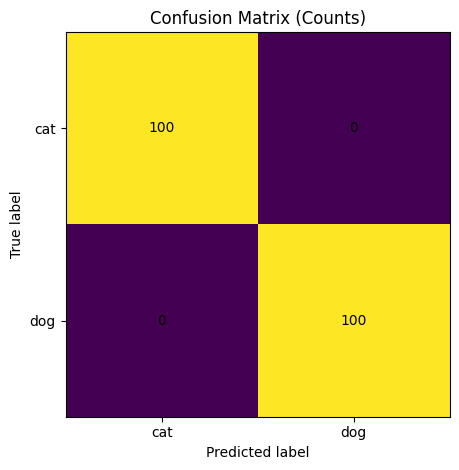

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], label_names[:2])
plt.yticks([0,1], label_names[:2])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()


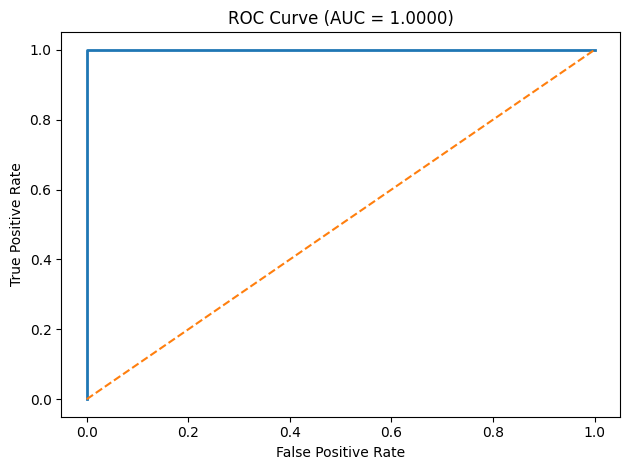

In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


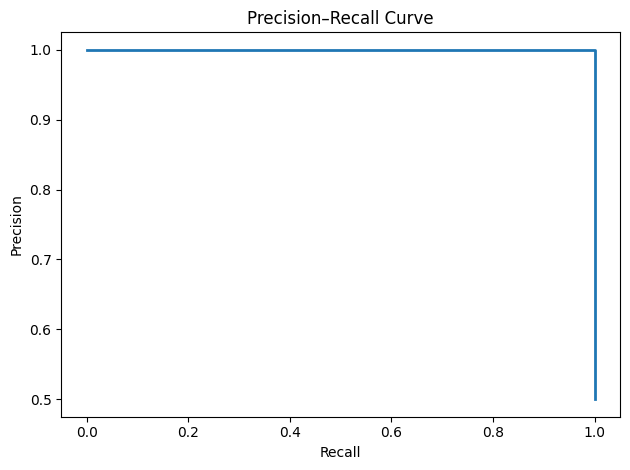

In [45]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)

plt.figure()
plt.plot(recall, precision, linewidth=2)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


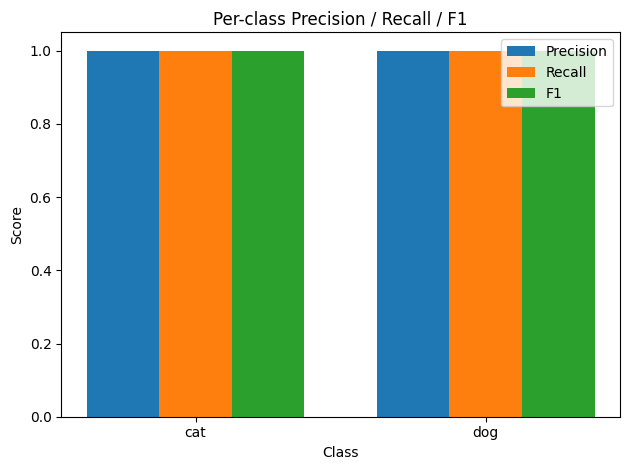

Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       100
           1     1.0000    1.0000    1.0000       100

    accuracy                         1.0000       200
   macro avg     1.0000    1.0000    1.0000       200
weighted avg     1.0000    1.0000    1.0000       200



In [43]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
classes = [k for k in report.keys() if k.isdigit()]
prec = [report[c]["precision"] for c in classes]
rec  = [report[c]["recall"] for c in classes]
f1   = [report[c]["f1-score"] for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure()
plt.bar(x - width, prec, width, label="Precision")
plt.bar(x,         rec,  width, label="Recall")
plt.bar(x + width, f1,   width, label="F1")
plt.xticks(x, [label_names[int(c)] if int(c) < len(label_names) else c for c in classes])
plt.title("Per-class Precision / Recall / F1")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report:\n")
print(classification_report(y_true, y_pred, digits=4))
